In [1]:
from scipy.integrate import *
from numpy import *
from pylab import *
from scipy import *
import pandas as pd

In [2]:
# function to be integrated

def hz_model(y, t, mu, lam, phi, beta, delta):
    H,Z = y
    dHdt = (mu*H) - (lam*((phi*H*Z)/(lam+phi*H)))
    dZdt = ((beta - 1)*lam*((phi*H*Z)/(lam+phi*H))) - (delta*Z)
    return dHdt, dZdt

In [3]:
# calling odeint

def integrate(params,inits,htimes,vtimes,forshow=False,delt=900.0 / 86400.0):
    days = amax(htimes)
    times = arange(0,days,delt)
    mu, lam, phi, beta, delta = exp(params[0]),exp(params[1]),exp(params[2]),exp(params[3]), exp(params[4]) # parameters
    u = odeint(hz_model,inits,times,args=(mu, lam, phi, beta, delta))
    u = u.T
    if forshow==False:
        hinds = r_[[where(abs(a-times)==min(abs(a-times)))[0][0] for a in htimes]] # get time indices where host abundances were measured
        vinds = r_[[where(abs(a-times)==min(abs(a-times)))[0][0] for a in vtimes]] # same for viruses
        hnt = u[0][hinds]  # host density
        vnt = u[1][vinds] # virus density
    else:
        hnt = u[0]
        vnt = u[1]
    return hnt,vnt

In [4]:
# load in the data

#host data

dS_csv = pd.read_csv('Kimura_66_67_fig7d_host_control.txt',delimiter=',')
#print(dS_csv)
unlogS = 10**(dS_csv['abundance'])
#print(unlogS)

#times, host = read.text("..."), unpack = True, ...

#dS_csv["time"] = dS_csv["time"]/24.0
dS_csv["time"] = dS_csv["time"]

dI_csv = pd.read_csv('Kimura_66_67_fig7f_host_infected.txt',delimiter=',')
#print(dI_csv)

hhtemp = 10**(dI_csv['abundance'])
#print(unlogI)

#htimes = dI_csv["time"]/24.0
#print(htimes)
htimes = dI_csv["time"]

hhtempsd = ma.mean(hhtemp)*0.1 # these data did not come with standard deviations so i made them up


#virus data

dV_csv = pd.read_csv('Kimura_66_67_fig7f_viral_abundance.txt',delimiter=',')
#print(dV_csv)

vhtemp = 10**(dV_csv['virus'])
#print(unlogV)

#vtimes = dV_csv["time"]/24.0
vtimes = dV_csv["time"]

vhtempsd = ma.mean(vhtemp)*0.1 # these data did not come with standard deviations so i made them up


In [5]:
# generic arrays and optimization parameters


stds = zeros(5) + .05 # this controls how large the random steps are in the parameter search (see below)


opt = r_[[1,1,1,1,1]] # this allows you to control whether each parameter is imposed or fitted


names = ['muh','lam','phi','beta','delta'] # name each parameter array - useful for printing the output



nits = 1000 # number of iterations


pits = 100  # frequency with which to print results to the user about the progress of the algorithm


burnin = 100 # burnin period - don't 'store' the results for the first number of iterations as these are likely to be very far from the optimal ssolutions


In [30]:
# MODEL FITTING

## set up first guess params, MHA parameters, etc. 

mu = 0.978
lam = 0.704
phi = 0.0000000191
#phi = 0.0000000382
#beta = 257.54
beta = 128.77
delta = 0.002

# put in arrays for ease manipulating


params = r_[[mu,lam,phi,beta,delta]] # put inside a single array ready for the algorithm


params = log(params) # we do the parameter search in log space (I will explain later)


npars = params.shape[0] # number of parameters being searched through


# initial conditions


inits = r_[[hhtemp[0]+unlogS[0],vhtemp[0]]]


In [31]:
# first run just to get error


hnt,vnt = integrate(params,inits,htimes,vtimes)


chi =   sum((hnt - hhtemp) ** 2 / (hhtempsd ** 2)) + sum((vnt - vhtemp) ** 2 / (vhtempsd ** 2))        

In [32]:
# distribution arrays and acceptance ratios - these are containers to be added to

ar = 0.0


ars = r_[[]]


mus,lams,phis,betas,deltas= r_[[]],r_[[]],r_[[]],r_[[]],r_[[]]


pall = [mus,lams,phis,betas,deltas]

In [33]:
# now actually do the fitting

for it in arange(1,nits,1):
        parsnew = params + opt*normal(0,stds,npars) # this is where we randomly change the parameter values 
        sus,vir = hhtemp[0],vhtemp[0] # have to reassign initial conditions because it's in a loop
        inits = r_[[sus,vir]] # put initial conditions in an array
        hnt,vnt = integrate(parsnew,inits,htimes,vtimes) # call the integration function
        chinew = sum((hnt - hhtemp) ** 2 / (hhtempsd ** 2)) +sum((vnt - vhtemp) ** 2 / (vhtempsd ** 2)) # calculate the error
        if exp(chi-chinew) > rand(): # KEY STEP
            chi = chinew 
            params = parsnew #  new parameters can be a little bit 'wrong'
            if it > burnin: # only store the parameters if you've gone through the burnin period
                pall = append(pall,params[:,None],1)
            ar = ar + 1.0 # acceptance ratio - I can explain this another time
        if (it % pits == 0):
            print(it,chi,ar/pits)
            ars = append(ars,ar/pits)
            ar = 0.0


100 1583.846288759847 0.15
200 1561.1406315595825 0.06
300 1541.7080612111304 0.03
400 1537.971061018441 0.02
500 1537.971061018441 0.0
600 1458.2025295748713 0.05
700 1434.1777148352512 0.06
800 1428.2769081681377 0.02
900 1428.2769081681377 0.0


In [34]:
# print output to screen


print('Optimal parameters')


pars = r_[[ mean(p) for p in pall]]


for (p,l) in zip(pars,names):
    print(l,'=',exp(p))


print (' ')


print('Standard deviations')


for (p,l) in zip(pall,names):
    print(l+'std','=',std(exp(p)))


print(' ')


Optimal parameters
muh = 0.9289756681625306
lam = 1.0023652635703753
phi = 8.00941136325423e-09
beta = 207.45103613445667
delta = 0.0015623431496049381
 
Standard deviations
muhstd = 0.06894567746961047
lamstd = 0.04199496482814998
phistd = 9.691790654489476e-10
betastd = 19.2007315288533
deltastd = 7.742272521625197e-05
 


In [35]:
# redefine times for nicer looking plots

delt = 900.0 / 86400.0

ftimes = linspace(0,amax(htimes)/24.0,(amax(htimes) / delt)+1)*24.0

n = ftimes.shape[0]

/Users/kylabeth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """


In [36]:

# run again just for nicer looking plots (more even timesteps)


sus,vir = hhtemp[0],vhtemp[0]


inits = r_[[sus,vir]]


hnt,vnt = integrate(pars,inits,ftimes,ftimes,forshow=True,delt=delt)


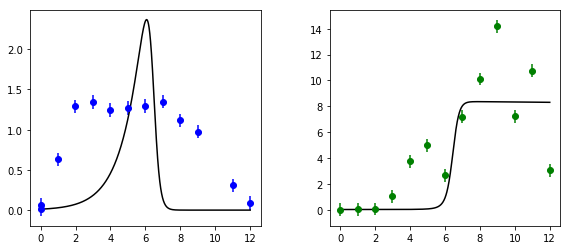

In [37]:
# set up figures

f1,ax1 = subplots(1,2,figsize=[9.5,4.0])
#f2,ax2 = subplots(4,1,figsize=[6,15])
f1.subplots_adjust(bottom=0.13,wspace=0.3,hspace=0.3)
#f2.subplots_adjust(hspace=0.45)


# plot

ax1[0].errorbar(htimes,hhtemp/1e+6,yerr=hhtempsd/1e+6,c='blue',fmt='o')
ax1[1].errorbar(vtimes,vhtemp/1e+8,yerr=vhtempsd/1e+8,c='green',fmt='o')
ax1[0].plot(ftimes,hnt/1e+6,c='black',lw=1.5,label='model fit')
ax1[1].plot(ftimes,vnt/1e+8,c='black',lw=1.5,label='model fit')



# high temp

#ax2[0].hist(exp(pall[1]),label='25 C',color='maroon')
#ax2[1].hist(exp(pall[0])*1e+9,label='25 C',color='maroon')
#ax2[2].hist(exp(pall[2]),label='25 C',color='maroon')
#ax2[3].hist(exp(pall[3]),label='25 C',color='maroon')
